In [1]:
import numpy as np
import xsimlab as xs
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [6]:
@xs.process
class UniformGrid1D:
    """Create a 1-dimensional, equally spaced grid."""

    spacing = xs.variable(description="uniform spacing", static=True)
    length = xs.variable(description="total length", static=True)
    x = xs.index(dims="x")

    def initialize(self):
        self.x = np.arange(0, self.length, self.spacing)

In [7]:
@xs.process
class ProfileU:
    """Compute the evolution of the profile of quantity `u`."""

    u_vars = xs.group("u_vars")
    u = xs.variable(
        dims="x", intent="inout", description="quantity u", attrs={"units": "m"}
    )

    def run_step(self):
        #print(list(self.u_vars))
        self._delta_u = sum((v for v in self.u_vars))
        
        #print('hey',list(self.u_vars))

    def finalize_step(self):
        self.u += self._delta_u

In [8]:
@xs.process
class AdvectionLax:
    """Advection using finite difference (Lax method) on
    a fixed grid with periodic boundary conditions.

    """

    v = xs.variable(dims=[(), "x"], description="velocity")
    grid_spacing = xs.foreign(UniformGrid1D, "spacing")
    u = xs.foreign(ProfileU, "u")
    u_advected = xs.variable(dims="x", intent="out", groups="u_vars")

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        factor = self.v / (2 * self.grid_spacing)

        u_left = np.roll(self.u, 1)
        u_right = np.roll(self.u, -1)
        u_1 = 0.5 * (u_right + u_left) - factor * dt * (u_right - u_left)

        self.u_advected = u_1 - self.u

In [9]:
@xs.process
class InitUGauss:
    """Initialize `u` profile using a Gaussian pulse."""

    loc = xs.variable(description="location of initial pulse", static=True)
    scale = xs.variable(description="scale of initial pulse", static=True)
    x = xs.foreign(UniformGrid1D, "x")
    u = xs.foreign(ProfileU, "u", intent="out")

    def initialize(self):
        self.u = np.exp(-1 / self.scale ** 2 * (self.x - self.loc) ** 2)

In [10]:
advect_model = xs.Model(
    {
        "grid": UniformGrid1D,
        "profile": ProfileU,
        "init": InitUGauss,
        "advect": AdvectionLax,
    }
)

In [13]:
# additional process
@xs.process
class SourcePoint:
    """Source point for quantity `u`.

    The location of the source point is adjusted to coincide with
    the nearest node the grid.

    """

    loc = xs.variable(description="source location")
    flux = xs.variable(description="source flux")
    x = xs.foreign(UniformGrid1D, "x")
    u_source = xs.variable(dims="x", intent="out", groups="u_vars")

    @property
    def nearest_node(self):
        idx = np.abs(self.x - self.loc).argmin()
        return idx

    @property
    def source_rate(self):
        src_array = np.zeros_like(self.x)
        src_array[self.nearest_node] = self.flux
        return src_array

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self.u_source = self.source_rate * dt

In [14]:
in_ds = xs.create_setup(
     model=advect_model,
     clocks={
         'time': np.linspace(0., 1., 1001),
         'otime': [0, 0.1, 0.5, 1]
     },
     master_clock='time',
     input_vars={
         'grid': {'length': 1.5, 'spacing': 0.01},
         'init': {'loc': 0.3, 'scale': 0.1},
         'advect__v': 1.
     },
     output_vars={
         'profile__u': 'otime'
     }
 )

In [15]:
from xsimlab.monitoring import ProgressBar

with ProgressBar(frontend='console'):
    out_ds = in_ds.xsimlab.run(model=advect_model, parallel=False)

██████████ 100% | Simulation finished in 00:01 


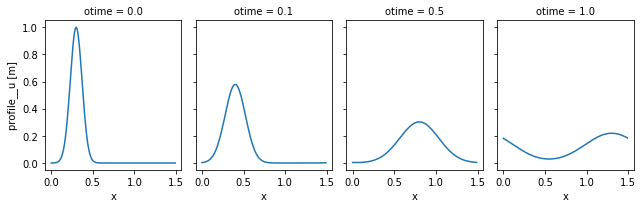

In [16]:
out_ds.profile__u.plot(col='otime', figsize=(9, 3));

# NEW Prototype, based on dims array

In [189]:
# this could be the 1d line of chemostats
@xs.process
class UniformGrid1D:
    """Create a 1-dimensional, equally spaced grid."""

    spacing = xs.variable(description="uniform spacing", static=True)
    length = xs.variable(description="total length", static=True)
    x = xs.index(dims="x")

    def initialize(self):
        self.x = np.arange(0, self.length, self.spacing)

In [ ]:
# what i would need essentially, is...
# to figure out if there is one array for all component states, and each flux is another array of flux that is added to this component in a class like below
# there can be as many fluxes as are added to the model, BUT the fluxes need to have access to each component
so I would have a class for each component, that tracks the parameters and initialisation
then in a higher level class, all of these components get combined and flattened to be an index
and then each FLUX calls the state and labels from this higher level class, and computes what is necessary below.

In [64]:
# This definitely also makes sense, but just as construction help for future components (and building block of the current ones)
@xs.process
class Time:
    days = xs.variable(dims='time', description='time in days')
    # for indexing xarray IO objects
    # NOTE: this is what allows storing the output along time properly even when using odeint!
    time = xs.index(dims='time', description='time in days')
    
    def initialize(self):
        self.time = self.days

@xs.process
class Component:
    """Base class encoding behaviour for a component of a ecosystem.
        subclass needs to have implemented:
        self.num, self.component_label, self.init, 
        
    """
    def initialize(self):
        if self.num:
            self.label = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])
            self.init = np.array([self.initVal for i in range(self.num)])
        else:
            self.label = self.component_label
            self.init = self.initVal
        self.c_state = self.init
        print(self.label)
        print(self.init)
        
    def run_step(self):
        self._delta_c = sum((v for v in self.c_fluxes))

    def finalize_step(self):
        self.c_state += self._delta_c

@xs.process
class Nutrient(Component):
    """"""
    component_label = xs.variable(default='N', groups='component-label', static=True)
    label = xs.index(dims='N')
    init = xs.variable(dims='N',intent='out')
    
    num = xs.variable(intent='in', static=True, description='number of Phytoplankton')
    initVal = xs.variable(default=1)
    
    fluxes = xs.group('n_flux')
    state = xs.variable(dims='N', groups='state-variable', intent='out', description='component array', attrs={'units': 'µM N'})

            
@xs.process
class Phytoplankton(Component):
    """"""
    component_label = xs.variable(default='P', groups='component-label', static=True)
    label = xs.index(dims='P')
    init = xs.variable(dims='P',intent='out')
    
    initVal = xs.variable(default=1)
    
    fluxes = xs.group('p_flux')
    state = xs.variable(dims='P', groups='state-variable', intent='out', description='component array', attrs={'units': 'µM N'})
    
    # PARAMETERS
    num = xs.variable(intent='in', groups='parameters', static=True, description='number of Phytoplankton')
    halfsat = xs.variable(dims=[(), 'P'], groups='parameters')

@xs.process
class PhytoplanktonGrowth:
    """"""
    growth = xs.variable(
        dims='P',
        intent='out',
        #groups=['p_flux'],
        description='phytoplankton growth, under light & nutrient limitation'
    )
    
@xs.process
class NutrientUptake(PhytoplanktonGrowth):
    """"""
    N = xs.foreign(Nutrient, 'state')
    P = xs.foreign(Phytoplankton, 'state')
    P_halfsat = xs.foreign(Phytoplankton, 'halfsat')
    
    def run_step(self):
        self.growth = self.N / (self.P_halfsat + self.N) * self.P
    
    
@xs.process
class Forcing:
    """Sum up all forcing processes and their effects, respectively.
    """
    pass
    

class NutrientSource(Forcing):
    """Chemostat constant nutrient inflow from one direction"""
    forcing_flux = xs.variable(
        dims=[(), 'N'],
        intent='out',
        groups='n_flux',
        description='constant nutrient influx'
    )

    #N = xs.foreign(Nutrient, 'state')
    
    #@xs.runtime(args='step_delta')
    def run_step(self):
        self.forcing_flux = 0.1


In [65]:
xs.Model({'N':Nutrient, 'P':Phytoplankton, 'N_Uptake':NutrientUptake, 'N_source':NutrientSource})

<xsimlab.Model (4 processes, 7 inputs)>
N
    num                 [in] number of Phytoplankton
    component_label     [in]
    initVal             [in]
P
    halfsat             [in] () or ('P',) 
    num                 [in] number of Phytoplankton
    component_label     [in]
    initVal             [in]
N_Uptake
N_source

# SO the trick I think is= 
initialize the "array" in another process
this allows high flexibility, since that other process can have more complex functions behind the parameters passed in

this would be a beautiful way to set up the size based allometries for example

and that way the current state can be calculated within that process

the only remaining question is then: how to pass state to fluxes.. (perhaps need new argument here? any_object? _model_context?_

In [ ]:
@xs.process
class ProfileC:
    """Compute the evolution of the profile of quantity `u`."""

    c_fluxes = xs.group("c_flux")
    c_state = xs.variable(
        dims="NPZD", intent="inout", description="component array", attrs={"units": "µM N"}
    )

    def run_step(self):
        self._delta_c = sum((v for v in self.c_fluxes))
        
        #print('hey',list(self.u_vars))

    def finalize_step(self):

        self.c_state += self._delta_c

In [132]:
# GOAL: test whether groups can be accumulated in other class, which is then referenced by component

@xs.process
class INIT:
    """Create a 1-dimensional, array of NPZD component states and labels."""
    numberofcomps = xs.variable(description="total length", static=True) # here all the label & state inputs enter, and they get flattened below, and assigned
    components = xs.index(dims="C") #x!
    def initialize(self):
        self.components = np.arange(0., self.numberofcomps)  

@xs.process
class Component:
    fluxes = xs.group('flux')
    value = xs.variable(dims='C', intent='inout')
    
    # PARAMETER
    v = xs.variable(dims=[(), "C"], description="velocity")
    
    def run_step(self):
        self._delta = sum((v for v in self.fluxes))
        print(self._delta)

    def finalize_step(self):
        self.value += self._delta
    
    
@xs.process
class InitC:
    """Initialize `u` profile using a Gaussian pulse."""

    components = xs.foreign(INIT, "components")
    value = xs.foreign(Component, "value", intent="out")

    def initialize(self):
        self.value = self.components
        
#
        
@xs.process
class oneFlux:
    #c_state = xs.foreign(ProfileC, "c_state")
    value = xs.foreign(Component, 'value')#, intent='out')
    
    v = xs.foreign(Component, 'v') #xs.variable(dims=[(), "C"], description="velocity")
    
    value_out = xs.variable(dims="C", intent="out", groups="flux")

    @xs.runtime(args="step_delta")
    def run_step(self, dt):

        growth= self.v/10
        
        self.value_out = growth + self.value

@xs.process
class twoFlux:
    #c_state = xs.foreign(ProfileC, "c_state")
    value = xs.foreign(Component, 'value')#, intent='out')
    
    v = xs.foreign(Component, 'v') #xs.variable(dims=[(), "C"], description="velocity")
    
    value_out = xs.variable(dims="C", intent="out", groups="flux")

    @xs.runtime(args="step_delta")
    def run_step(self, dt):

        growth= self.v/10
        
        self.value_out = growth + self.value
    
        
@xs.process
class checkVal:
    val = xs.foreign(Component, 'value', intent='in')
    
    def run_step(self):
        print(self.val)
#The answer is NO

#but variables can be initialized with xs.foreign as well!
#is that maybe useful?? 

In [133]:
test = xs.Model({'C':Component, 'F':oneFlux, 'f2':twoFlux, 'InitC':InitC, 'INIT':INIT})

In [134]:
test

<xsimlab.Model (5 processes, 2 inputs)>
INIT
    numberofcomps     [in] total length
InitC
F
f2
C
    v                 [in] () or ('C',) velocity

In [135]:
testin_ds = xs.create_setup(
     model=test,
     clocks={
         'time': np.linspace(0., 10., 11)#,
         #'otime': [0, 0.1, 0.5, 1]
     },
     master_clock='time',
     input_vars={
        'INIT__numberofcomps':1,  #'grid__numberofcomps':3,
         'C__v':1
         #'advect__v': 1.
     },
     output_vars={
         'C__value':'time'#'profile__c_state': 'time'
     }
 )

In [136]:
with test:
    out= testin_ds.xsimlab.run()

[0.2]
[0.6]
[1.8]
[5.4]
[16.2]
[48.6]
[145.8]
[437.4]
[1312.2]
[3936.6]


In [126]:
out

<xarray.Dataset>
Dimensions:              (C: 1, time: 11)
Coordinates:
  * time                 (time) float64 0.0 1.0 2.0 3.0 4.0 ... 7.0 8.0 9.0 10.0
Dimensions without coordinates: C
Data variables:
    C__value             (time, C) float64 0.0 0.1 0.3 0.7 ... 25.5 51.1 102.3
    F__v                 int64 1
    INIT__numberofcomps  int64 1
    components           (C) float64 102.3

In [ ]:
# another instance of how to create kinds of processes that can interact with other processes
# like the process takes the whole array 1D of state variables, but only modifies the ones it should [like all 'P's etc.]
@xs.process
class BaseIsostasy:
    """Base class for isostasy.
    Do not use this base class directly in a model! Use one of its
    subclasses instead.
    However, if you need one or several of the variables declared here
    in another process, it is preferable to pass this base class in
    :func:`xsimlab.foreign`.
    """
    rebound = xs.variable(
        dims=('y', 'x'),
        intent='out',
        groups=['bedrock_upward', 'surface_upward'],
        description='isostasic rebound due to material loading/unloading'
    )

In [41]:
Phytoplankton(num=3).initialize()

['P-1' 'P-2' 'P-3']
[1 1 1]


In [70]:
# this needs to be the NPZD model array

# i think this could flatten each class being initialized.. but does it need to?
@xs.process
class NPZD_1D:
    """Create a 1-dimensional, array of NPZD component states and labels."""

    numberofcomps = xs.variable(description="total length", static=True) # here all the label & state inputs enter, and they get flattened below, and assigned
    
    components = xs.index(dims="NPZD") #x!

    def initialize(self):
        self.components = np.arange(0., self.numberofcomps)

In [71]:
@xs.process
class ProfileC:
    """Compute the evolution of the profile of quantity `u`."""

    c_fluxes = xs.group("c_flux")
    c_state = xs.variable(
        dims="NPZD", intent="inout", description="component array", attrs={"units": "µM N"}
    )

    def run_step(self):
        self._delta_c = sum((v for v in self.c_fluxes))
        
        #print('hey',list(self.u_vars))

    def finalize_step(self):

        self.c_state += self._delta_c

In [72]:
# so the thing is that I want components to be multidimensional:

@xs.process
class NutrientUptake:
    """Advection using finite difference (Lax method) on
    a fixed grid with periodic boundary conditions.

    """

    v = xs.variable(dims=[(), "c"], description="velocity")
    #grid_spacing = xs.foreign(UniformGrid1D, "spacing")
    
    c_state = xs.foreign(ProfileC, "c_state")
    
    c_growth = xs.variable(dims="x", intent="out", groups="c_flux")

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        #factor = self.v / (2 * self.grid_spacing)

        #q_left = np.roll(self.q, 1)
        #q_right = np.roll(self.q, -1)
        #q_1 = 0.5 * (q_right + q_left) - factor * dt * (q_right - q_left)
        growth= self.v/10
        
        self.c_growth = growth * self.c_state

In [73]:
@xs.process
class InitCStates:
    """Initialize `u` profile using a Gaussian pulse."""

    components = xs.foreign(NPZD_1D, "components")
    c_state = xs.foreign(ProfileC, "c_state", intent="out")

    def initialize(self):
        self.c_state = self.components

In [75]:
advect_model = xs.Model(
    {
        "grid": NPZD_1D,
        "profile": ProfileC,
        "init": InitCStates,
        "advect": NutrientUptake,
    }
)

In [76]:
in_ds = xs.create_setup(
     model=advect_model,
     clocks={
         'time': np.linspace(0., 1., 1001)#,
         #'otime': [0, 0.1, 0.5, 1]
     },
     master_clock='time',
     input_vars={
         'grid__numberofcomps':3,
         'advect__v': 1.
     },
     output_vars={
         'profile__c_state': 'time'
     }
 )

In [77]:
from xsimlab.monitoring import ProgressBar

with ProgressBar(frontend='console'):
    out_ds = in_ds.xsimlab.run(model=advect_model)

██████████ 100% | Simulation finished in 00:01 


In [78]:
out_ds

<xarray.Dataset>
Dimensions:              (NPZD: 3, time: 1001)
Coordinates:
  * time                 (time) float64 0.0 0.001 0.002 ... 0.998 0.999 1.0
Dimensions without coordinates: NPZD
Data variables:
    advect__v            float64 1.0
    components           (NPZD) float64 0.0 2.47e+41 4.94e+41
    grid__numberofcomps  int64 3
    profile__c_state     (time, NPZD) float64 0.0 1.0 2.0 ... 2.47e+41 4.94e+41

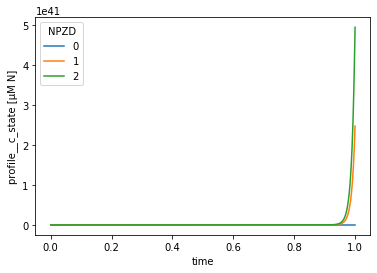

In [13]:
out_ds.profile__c_state.plot.line(x='time')

In [176]:
# this could do the grid exchanges, np.roll works like that
@xs.process
class AdvectionLax:
    """Advection using finite difference (Lax method) on
    a fixed grid with periodic boundary conditions.

    """

    v = xs.variable(dims=[(), "x"], description="velocity")
    grid_spacing = xs.foreign(UniformGrid1D, "spacing")
    u = xs.foreign(ProfileU, "u")
    u_advected = xs.variable(dims="x", intent="out", groups="u_vars")

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        factor = self.v / (2 * self.grid_spacing)

        u_left = np.roll(self.u, 1)
        u_right = np.roll(self.u, -1)
        u_1 = 0.5 * (u_right + u_left) - factor * dt * (u_right - u_left)

        self.u_advected = u_1 - self.u

In [177]:
@xs.process
class InitUGauss:
    """Initialize `u` profile using a Gaussian pulse."""

    loc = xs.variable(description="location of initial pulse", static=True)
    scale = xs.variable(description="scale of initial pulse", static=True)
    x = xs.foreign(UniformGrid1D, "x")
    u = xs.foreign(ProfileU, "u", intent="out")

    def initialize(self):
        self.u = np.exp(-1 / self.scale ** 2 * (self.x - self.loc) ** 2)

In [178]:
advect_model = xs.Model(
    {
        "grid": UniformGrid1D,
        "profile": ProfileU,
        "init": InitUGauss,
        "advect": AdvectionLax,
    }
)

In [179]:
in_ds = xs.create_setup(
     model=advect_model,
     clocks={
         'time': np.linspace(0., 1., 1001),
         'otime': [0, 0.1, 0.5, 1]
     },
     master_clock='time',
     input_vars={
         'grid': {'length': 1.5, 'spacing': 0.01},
         'init': {'loc': 0.3, 'scale': 0.1},
         'advect__v': 1.
     },
     output_vars={
         'profile__u': 'otime'
     }
 )

In [180]:
from xsimlab.monitoring import ProgressBar

with ProgressBar(frontend='console'):
    out_ds = in_ds.xsimlab.run(model=advect_model, parallel=False)

██████████ 100% | Simulation finished in 00:01 


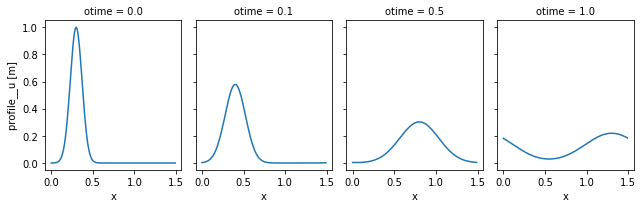

In [181]:
out_ds.profile__u.plot(col='otime', figsize=(9, 3));

In [66]:
@xs.process
class ChemostatCell:
    """Create a 1-dimensional array of components of this cell, keeps track of their value."""
    c_labels= xs.group('component_label')
    
    c = xs.index(dims='c', description='index of componentlabels for later use in xarray output')
    cellstate = xs.variable(dims='c', intent='out', description='variable storing the actual state of each component c')

    def initialize(self):
        self.c = np.array(list(self.c_labels))
        self.cellstate = np.array([n for n in range(len(self.c))])
        
        print(self.c)

In [67]:
@xs.process
class Phytoplankton:
    """Component class initializing components of type phytoplankton"""
    label_prefix = xs.variable(default='P')
    
    np = xs.variable(description='number of instances')
    
    #np = xs.index(dims='p_number')
    # note `dims` that allows either a unique instance or multiple instances
    label = xs.variable(dims=[(),'p_number'], groups='component_label', intent='out')
    init = xs.variable(dims=[(), 'p_number'], intent='in', groups='init')
    size = xs.variable(dims=[(), 'p_number'], intent='in', groups='size')

    # this component property is the same for all instances
    uptake = xs.variable(dims=[(),'p_number'])

    # this component property might have different values for instances
    #param2 = xs.variable(dims=[(),'p_number'])

    def initialize(self):
        if self.np:
            self.label = np.array([f"{self.label_prefix}-{i+1}" for i in range(self.np)])
        else:
            self.label = self.label_prefix
        
    def run_step(self):
        pass #print(self.label)

In [68]:
Chemostat = xs.Model({'Cell':ChemostatCell, 'P':Phytoplankton})

In [69]:
Chemostat

<xsimlab.Model (2 processes, 5 inputs)>
P
    init             [in] () or ('p_number',) 
    size             [in] () or ('p_number',) 
    np               [in] number of instances
    label_prefix     [in]
    uptake           [in] () or ('p_number',) 
Cell

In [70]:
chemo_ds = xs.create_setup(
     model=Chemostat,
     clocks={
         'time': np.linspace(0., 1., 10)# ,
         # 'otime': [0, 0.1, 0.5, 1]
     },
     master_clock='time',
     input_vars={
         'P': {'np':5, 'init': 1.5, 'size': 2},
         'P__uptake': np.array([1,2,3,4,5])
     },
     output_vars={
         'Cell__cellstate': 'time'
     }
 )

In [71]:
from xsimlab.monitoring import ProgressBar

with ProgressBar(frontend='console'):
    out_ds = chemo_ds.xsimlab.run(model=Chemostat, parallel=False)

██████████ 100% | Simulation finished in 00:00 

[['P-1' 'P-2' 'P-3' 'P-4' 'P-5']]


ValueError: Output array of 2 dimension(s) for variable 'c' doesn't match any of its accepted dimension(s): (('c',),)

In [ ]:
# this is the base class for a flux 
@xs.process
class flux:
    """Base class for fluxes.
    Do not use this base class directly in a model! Use one of its
    subclasses instead.
    However, if you need one or several of the variables declared here
    in another process, it is preferable to pass this base class in
    :func:`xsimlab.foreign`.
    """
    flux = xs.variable(
        dims=('y', 'x'),
        intent='out',
        groups='flux',
        description='change in state variables over time'
    )

In [ ]:
@xs.process
class StreamPowerChannel(ChannelErosion):
    """Stream-Power channel erosion."""

    k_coef = xs.variable(
        dims=[(), ('y', 'x')],
        description='parameter'
    )
    area_exp = xs.variable(
        default=0.4,
        description='drainage area exponent'
    )
    slope_exp = xs.variable(
        default=1,
        description='slope exponent'
    )

    shape = xs.foreign(UniformRectilinearGrid2D, 'shape')
    elevation = xs.foreign(FlowRouter, 'elevation')
    receivers = xs.foreign(FlowRouter, 'receivers')
    flowacc = xs.foreign(FlowAccumulator, 'flowacc')
    fs_context = xs.foreign(FastscapelibContext, 'context')

    chi = xs.on_demand(
        dims=('y', 'x'),
        description='integrated drainage area (chi)'
    )


    def run_step(self):
        kf = np.broadcast_to(self.k_coef, self.shape).flatten()
        self.fs_context["kf"] = kf

        # we don't use kfsed fastscapelib-fortran feature directly
        self.fs_context["kfsed"] = -1.

        self.fs_context["m"] = self.area_exp
        self.fs_context["n"] = self.slope_exp

        # bypass fastscapelib_fortran global state
        self.fs_context["h"] = self.elevation.flatten()

        # TODO: https://github.com/fastscape-lem/fastscapelib-fortran/pull/25
        # this has no effect yet.
        self.fs_context["a"] = self.flowacc.flatten()

        if self.receivers.ndim == 1:
            fs.streampowerlawsingleflowdirection()
        else:
            fs.streampowerlaw()

        erosion_flat = self.elevation.ravel() - self.fs_context["h"]
        self.erosion = erosion_flat.reshape(self.shape)

In [93]:
shape = (5, 5)

e = np.zeros(shape)

In [94]:
e

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [ ]:
@xs.process
class ModelSetup:
    """create flat array of state"""
    np = xs.variable(intent='in', description='number of phytoplankton components')
    nz = xs.variable(intent='in', description='number of zooplankton components')
    nn = xs.variable(default=1, description='nutrients - 1 component')
    nd = xs.variable(default=1, description='detritus - 1 component' )
    
    labels = 
    

In [133]:
@xs.process
class P:
    label_prefix = xs.variable(default='P')
    label = xs.variable(dims=[(), 'p_number'], intent='out', groups='component_label')
    
    np = xs.variable(intent='in', description='number of Ps')
    
    def initialize(self):
        if self.np:
            self.label = np.array([f"{self.label_prefix}-{i+1}" for i in range(self.np)])
        else:
            self.label = self.label_prefix
            
@xs.process
class Z:
    label_prefix = xs.variable(default='Z')
    label = xs.variable(dims=[(), 'z_number'], intent='out', groups='component_label')
    
    np = xs.variable(intent='in', description='number of Ps')
    
    def initialize(self):
        if self.np:
            self.label = np.array([f"{self.label_prefix}-{i+1}" for i in range(self.np)])
        else:
            self.label = self.label_prefix

In [169]:
@xs.process
class getFlatComponentArray:
    labels = xs.group('component_label')
    
    def initialize(self):
        print(np.array(list(self.labels)).reshape(1,2))

In [170]:
tx1 = xs.Model({'P':P, 'Z':Z, 'FCA':getFlatComponentArray})

In [171]:
tx1

<xsimlab.Model (3 processes, 4 inputs)>
P
    np               [in] number of Ps
    label_prefix     [in]
Z
    np               [in] number of Ps
    label_prefix     [in]
FCA

In [172]:
tx1_in = xs.create_setup(
    model=tx1,
     clocks={
         'time': np.linspace(0., 1., 10)# ,
         # 'otime': [0, 0.1, 0.5, 1]
     },
     master_clock='time',
     input_vars={
         'P__np':2,
         'Z__np':4
     },
     output_vars={
         #'Cell__cellstate': 'time'
     })

In [173]:
tx1_in.xsimlab.run(model=tx1)

jee
[[array(['P-1', 'P-2'], dtype='<U3')
  array(['Z-1', 'Z-2', 'Z-3', 'Z-4'], dtype='<U3')]]


<xarray.Dataset>
Dimensions:          (time: 10)
Coordinates:
  * time             (time) float64 0.0 0.1111 0.2222 ... 0.7778 0.8889 1.0
Data variables:
    P__label_prefix  <U1 'P'
    P__np            int64 2
    Z__label_prefix  <U1 'Z'
    Z__np            int64 4